Predictions stored at /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_wt_k3.csv | RMSE: 1.13
Predictions stored at /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_wt_k5.csv | RMSE: 1.08
Predictions stored at /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_wt_k10.csv | RMSE: 1.05


IntText(value=1, description='User ID:')

IntText(value=1, description='Movie ID:')

IntSlider(value=3, description='Neighbors:', max=7, min=3, step=2)

Button(description='Recommend', style=ButtonStyle())

Output()

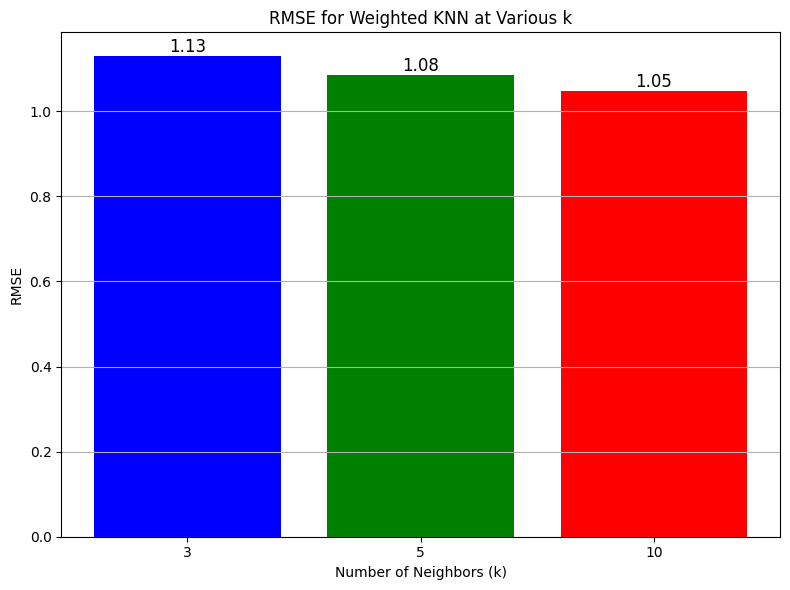

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt
import matplotlib.pyplot as plt

# Function to read data files
def fetch_data():
    movies = pd.read_csv('/Users/aryanpatelkolagani/Downloads/movies.csv')
    ratings = pd.read_csv('/Users/aryanpatelkolagani/Downloads/ratings.csv')
    return movies, ratings

# Combine ratings with movie details using movieId
def combine_data(movies, ratings):
    return pd.merge(ratings, movies, how='inner', on='movieId')

# Train KNN model and calculate RMSE
def compute_rmse(train_data, test_data, neighbors):
    X_train = train_data[['userId', 'movieId']]
    y_train = train_data['rating']
    X_test = test_data[['userId', 'movieId']]
    
    model = KNeighborsRegressor(n_neighbors=neighbors, weights='distance', metric='euclidean', n_jobs=-1)
    model.fit(X_train, y_train)
    
    predictions = np.round(model.predict(X_test), 2)
    test_data[f'pred_k{neighbors}'] = predictions
    
    error = sqrt(mean_squared_error(test_data['rating'], predictions))
    return error

# Predict and write output to file for multiple k values
def generate_predictions(train_data, test_data, k_list):
    X_train = train_data[['userId', 'movieId']]
    y_train = train_data['rating']
    X_test = test_data[['userId', 'movieId']]
    
    for k in k_list:
        model = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='euclidean', n_jobs=-1)
        model.fit(X_train, y_train)
        preds = np.round(model.predict(X_test), 2)
        test_data[f'pred_k{k}'] = preds
        error = sqrt(mean_squared_error(test_data['rating'], preds))
        
        output_path = f'/Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/KNN_Output_files/ratings_predictions_10_knn_wt_k{k}.csv'
        test_data.to_csv(output_path, columns=['userId', 'movieId', 'rating', f'pred_k{k}'], index=False)
        print(f"Predictions stored at {output_path} | RMSE: {error:.2f}")

# Load and merge datasets
movies_df, ratings_df = fetch_data()
merged_data = combine_data(movies_df, ratings_df)

# Split the dataset
train_set, test_set = train_test_split(merged_data, test_size=0.1, random_state=42)

# Generate and save predictions for specified k values
generate_predictions(train_set, test_set.copy(), [3, 5, 10])

# Widgets for interactive rating prediction
user_input = widgets.IntText(value=1, description='User ID:')
movie_input = widgets.IntText(value=1, description='Movie ID:')
k_slider = widgets.IntSlider(value=3, min=3, max=7, step=2, description='Neighbors:')
predict_btn = widgets.Button(description='Recommend')
output_box = widgets.Output()

# Function to handle button click and display prediction
def recommend_movie(b):
    with output_box:
        clear_output()
        uid = user_input.value
        mid = movie_input.value
        k = k_slider.value

        if uid not in train_set['userId'].values:
            print("User ID not found.")
            return
        if mid not in train_set['movieId'].values:
            print("Movie ID not found.")
            return

        X_train = train_set[['userId', 'movieId']]
        y_train = train_set['rating']
        knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='euclidean', n_jobs=-1)
        knn_model.fit(X_train, y_train)

        new_data = pd.DataFrame([[uid, mid]], columns=['userId', 'movieId'])
        predicted = knn_model.predict(new_data)[0]

        movie_info = movies_df[movies_df['movieId'] == mid].to_dict('records')[0]
        print(f"Movie Info: {movie_info}")
        print(f"Predicted Rating (k={k}): {predicted:.2f}")

predict_btn.on_click(recommend_movie)
display(user_input, movie_input, k_slider, predict_btn, output_box)

# Calculate RMSE for k values and plot the results
rmse_vals = [compute_rmse(train_set, test_set, k) for k in [3, 5, 10]]
k_vals = [3, 5, 10]
bar_colors = ['blue', 'green', 'red']

plt.figure(figsize=(8, 6))
plt.bar(range(len(k_vals)), rmse_vals, color=bar_colors, align='center')
plt.xticks(range(len(k_vals)), k_vals)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('RMSE for Weighted KNN at Various k')
plt.grid(axis='y')

for idx, val in enumerate(rmse_vals):
    plt.text(idx, val + 0.01, f"{val:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()
